In [1]:
import tensorflow as tf
from keras import backend as K
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.misc import imresize
import json
import cv2

%matplotlib inline

Using TensorFlow backend.


### Variables

In [2]:
from evaluate import *

# Metrics evaluated for each model
fr_metrics = {
    'PSNR' : psnr,
    'SSIM' : ssim,
    'MSE' : mse,
#     'RMSE' : rmse,
#     'UQI' : uqi
}

nr_metrics = {
    'D_LAMBDA' : d_lambda,
    'BRISQUE' : brisque
}

axis_reverse = [ 
    'PSNR', 'SSIM', 'UQI'
]

In [3]:
# Models to be compared
models = {
    'SRGAN-MSE' : 'SRGAN with MSE',
    'SRGAN-VGG22' : 'SRGAN with VGG22',
    'SRGAN-VGG54' : 'SRGAN with VGG54',
    'SRResNet-MSE' : 'SRResNet with MSE',
    'SRResNet-VGG22' : 'SRResNet with VGG22',
    'VDSR' : 'VDSR',
    'SRCNN' : 'SRCNN',
}

In [4]:
# Images analyzed
image_names = {
    'bird' : 'Bird',
    'baboon' : 'Baboon',
    '126007' : 'Mountains',
    'lenna' : 'Lenna',
    'pepper' : 'Pepper',
    'baby' : 'Baby',
    'butterfly' : 'Butterfly',
}

### Loading Images

In [5]:
def load_images(image_name):
    # Returns { model_name : image }    
    path = 'Tradeoff/Images/'
    names = ['HR', 'LR', 'bicubic'] + list(models.keys())
    ext = '.png'

    images = {}
    for name in names:
        image_path = path + image_name + '_' + name + ext
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        images[name] = image;
        
    return images

### Evaluation

In [6]:
for image_name in image_names:
    # { model_name : { metric : value } } saved as image_name.json
    
    images = load_images(image_name)
    results = {}
    for model in models:
        metric_values = {}
        
        for metric, func in fr_metrics.items():
            metric_values[metric] = func(images[model], images['HR'])
        
        for metric, func in nr_metrics.items():
            path = 'Tradeoff/Images/'
            ext = '.png'
            image_path = path + image_name + '_' + model + ext
            metric_values[metric] = func(images[model], images['bicubic'], path=image_path)
        
        results[model] = metric_values
        
    path = 'Tradeoff/Results/' + image_name + '.json'
    with open(path, 'w') as file:
        json.dump(results, file)
    print('Analyzed ' + path)

Analyzed Tradeoff/Results/bird.json
Analyzed Tradeoff/Results/baboon.json
Analyzed Tradeoff/Results/126007.json
Analyzed Tradeoff/Results/lenna.json
Analyzed Tradeoff/Results/pepper.json
Analyzed Tradeoff/Results/baby.json
Analyzed Tradeoff/Results/butterfly.json


### Plots

In [7]:
def get_single_image_values(image_name):
    file_name = 'Tradeoff/Results/' + image_name + '.json'
    try:
        with open(file_name, 'r') as file:
            values = json.load(file)
    except:
        print("Failed Loading JSON:", file_name)
        
    return values

In [8]:
def get_image_values(plot_images):
    values = {}
    for image_name in plot_images:
        values[image_name] = get_single_image_values(image_name)
    return values

In [9]:
def get_metric_values(plot_images, plot_metric, model, image_values):
    return [image_values[image_name][model][plot_metric] for image_name in plot_images]

### Images

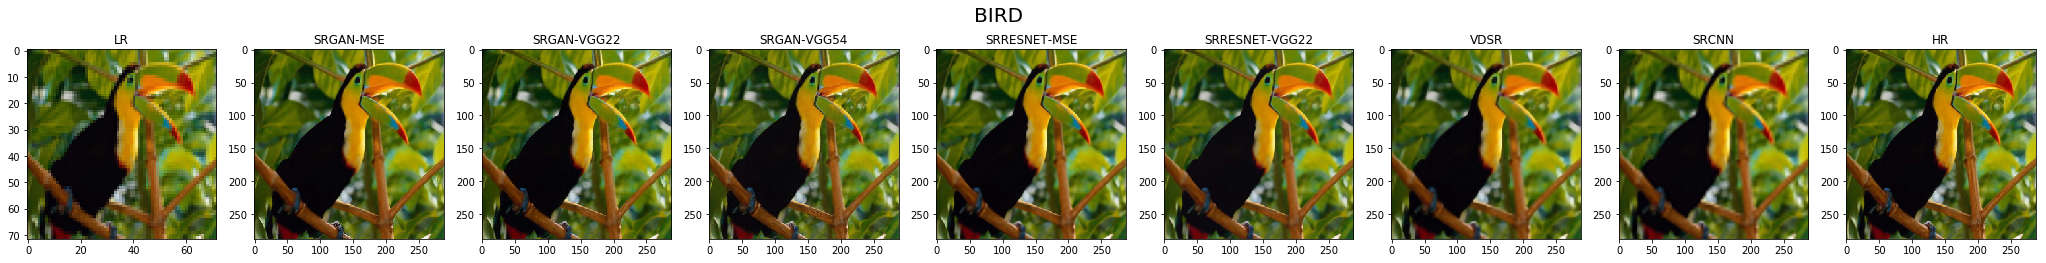

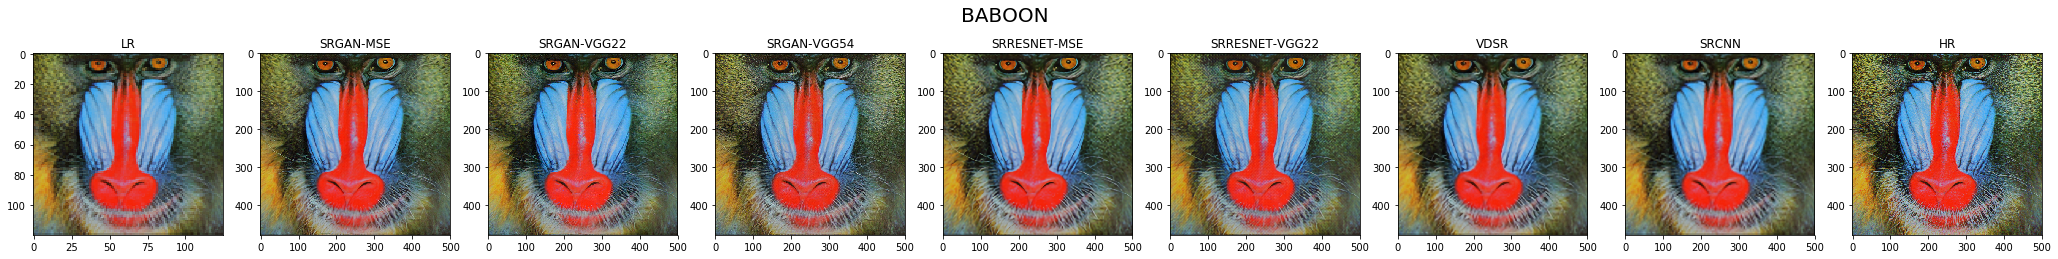

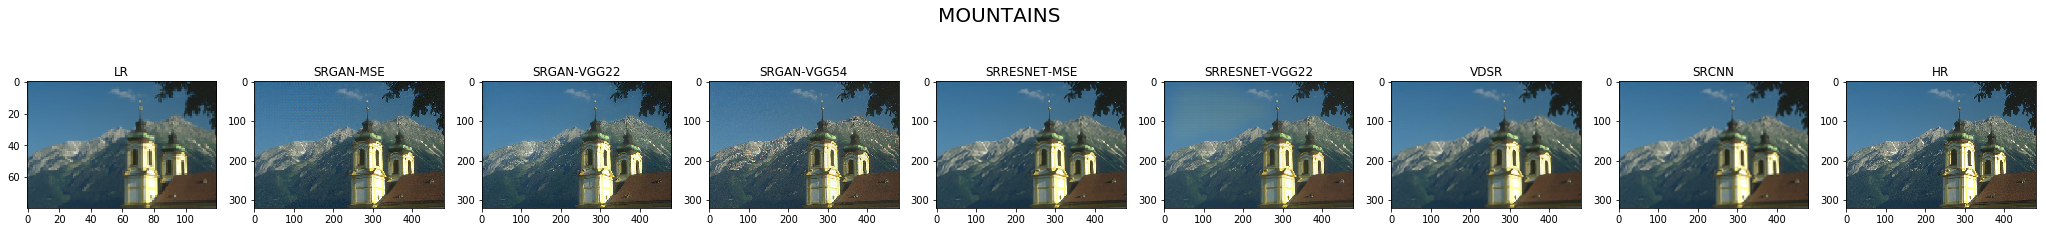

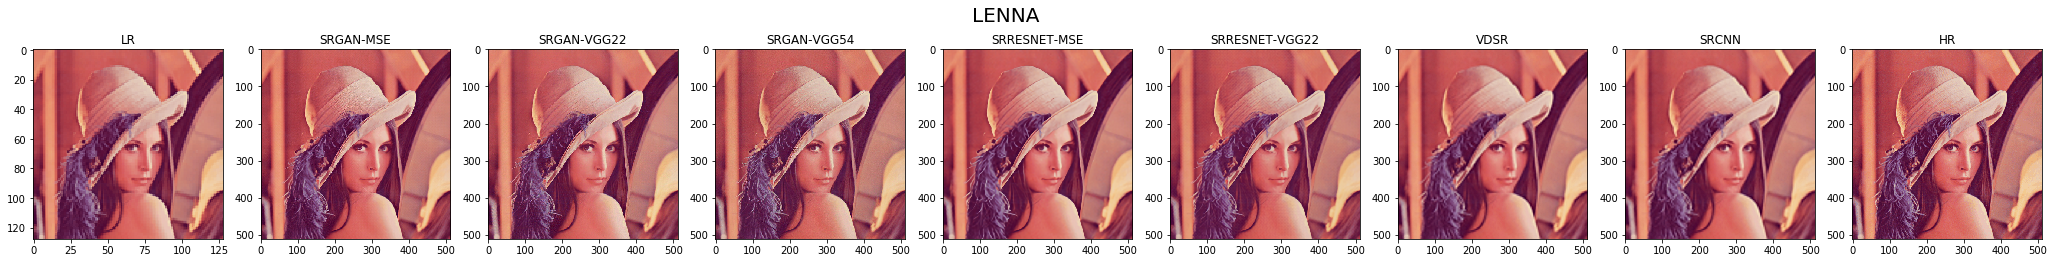

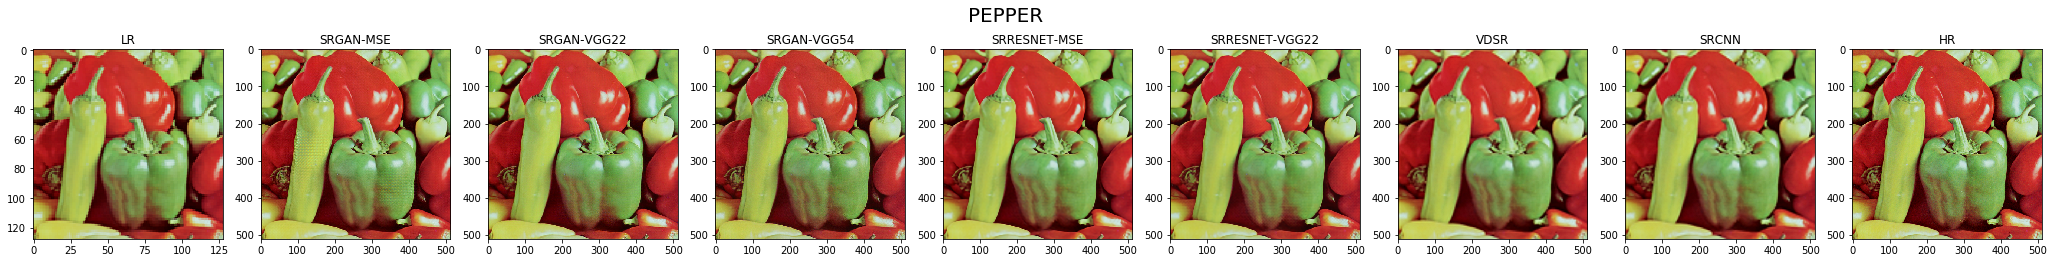

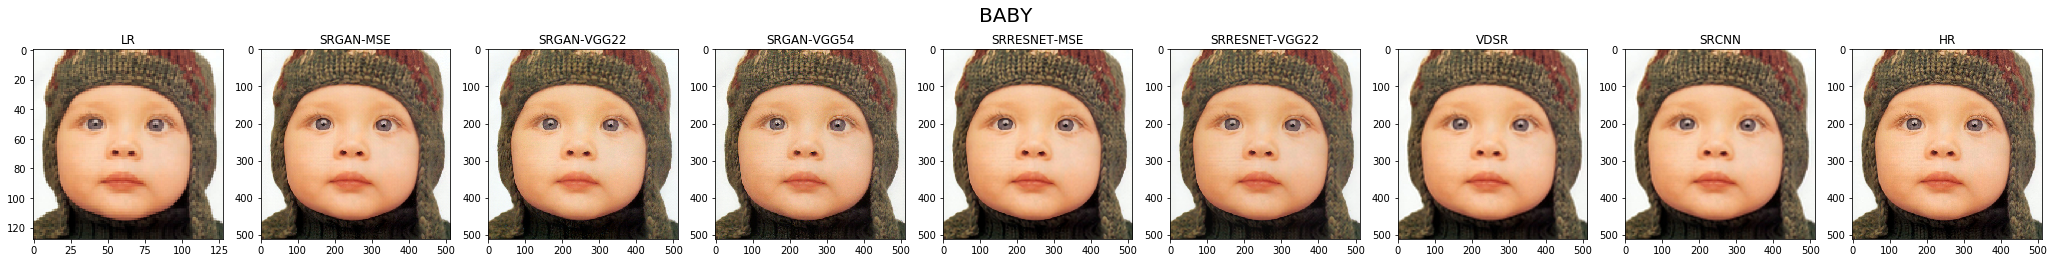

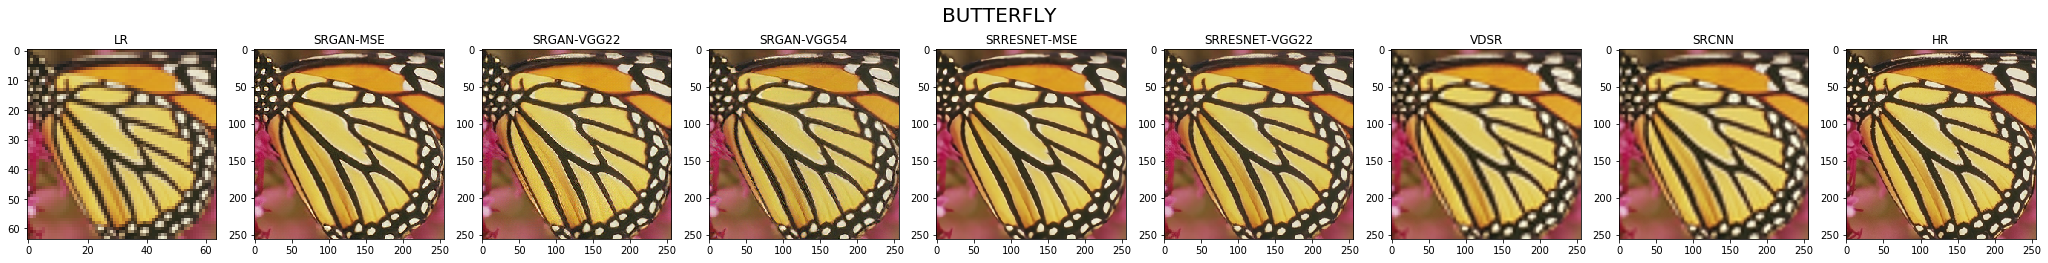

In [10]:
plot_models = models.keys()
plot_images = image_names.keys()

for image in plot_images:
#   LR + models + HR
    fig, sub = plt.subplots(1, len(plot_models)+2, figsize=(4*(len(plot_models)+2),4))
#     fig.suptitle(image.upper() + " (Comparing Models)", size=20)
    fig.suptitle(image_names[image].upper(), size=20)
    
    images = load_images(image)
    index = 0
    
    sub[index].imshow(cv2.cvtColor(images['LR'], cv2.COLOR_BGR2RGB))
    sub[index].set_title('LR')
    index = index + 1
    
    for model, image in images.items():
        if model not in ['LR', 'HR', 'bicubic']:
            sub[index].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            sub[index].set_title(model.upper())
            index = index + 1

    sub[index].imshow(cv2.cvtColor(images['HR'], cv2.COLOR_BGR2RGB))
    sub[index].set_title('HR')
    index = index + 1

    plt.show()

### Objective Quality

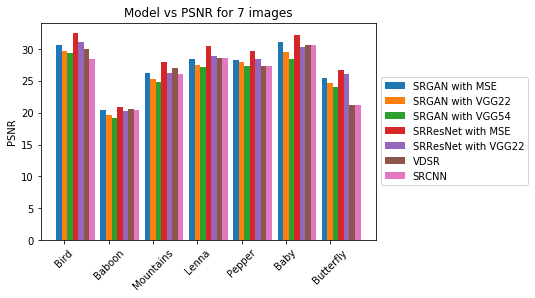

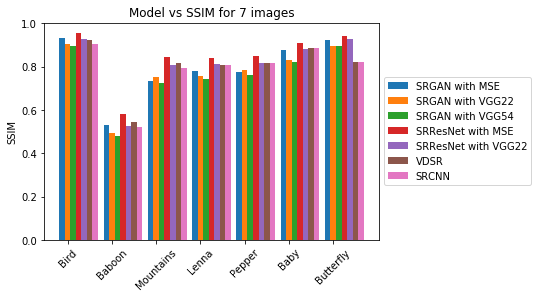

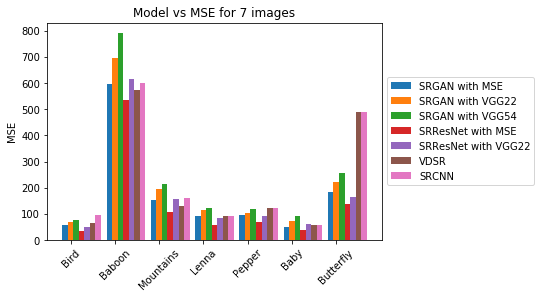

In [11]:
plot_metrics = fr_metrics.keys()
plot_images = image_names.keys()
plot_models = models.keys()

image_values = get_image_values(plot_images)

# necessary variables
width = 1/(len(plot_models)+1)
ind = np.arange(len(plot_images))

for plot_metric in plot_metrics:
    fig = plt.figure(1)
    sub = fig.add_subplot(111)

    # the bars
    rects = []
    for index, model in enumerate(plot_models):
        rects.append(
            sub.bar(
                ind + index*width, 
                get_metric_values(plot_images, plot_metric, model, image_values), 
                width
            )
        )

    # axes and labels
    sub.set_ylabel(plot_metric.upper())
    sub.set_title("Model vs " + plot_metric.upper() + " for " + str(len(plot_images)) + " images")
    sub.set_xticks(ind+width)
    plt.setp(sub.set_xticklabels([image_names[key] for key in plot_images]), rotation=45, fontsize=10)

    # legend
    sub.legend([r[0] for r in rects], [models[m] for m in plot_models], 
               loc='center left', bbox_to_anchor=(1.0, 0.5))

    plt.show()

### Tradeoff

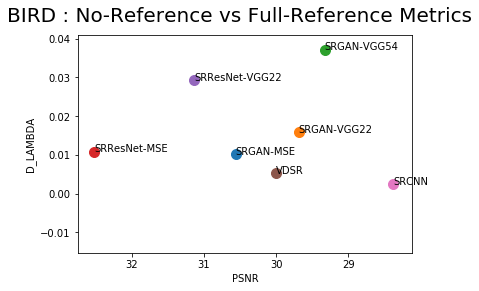

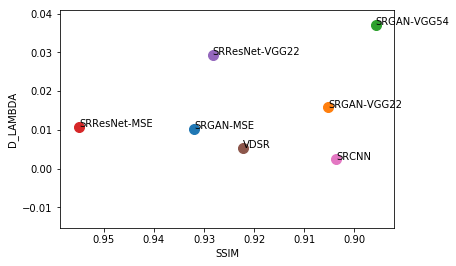

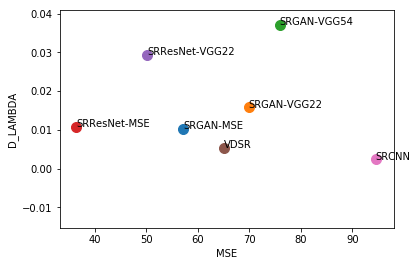

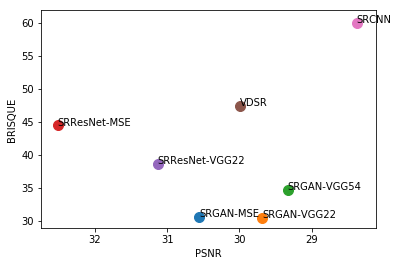

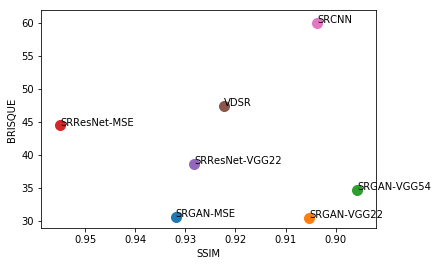

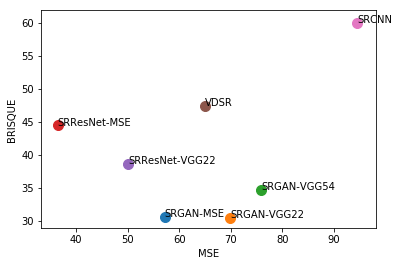

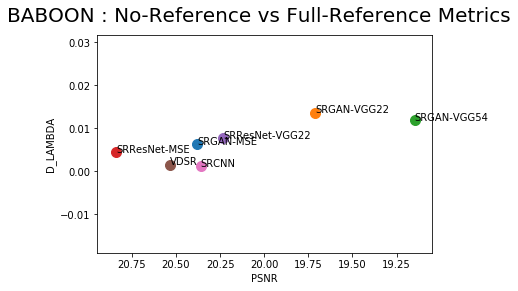

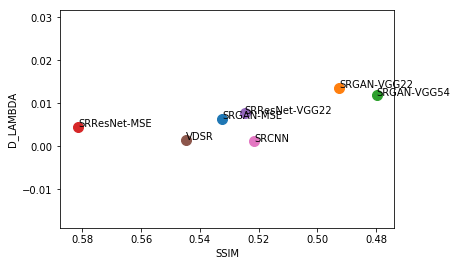

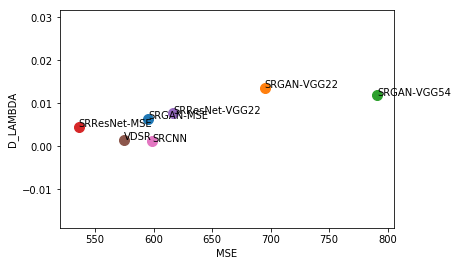

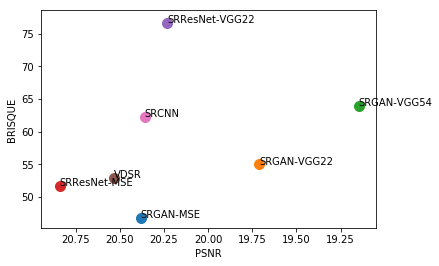

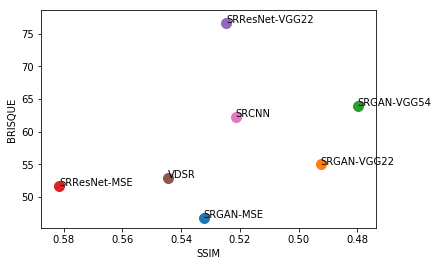

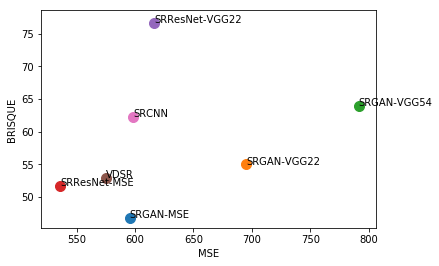

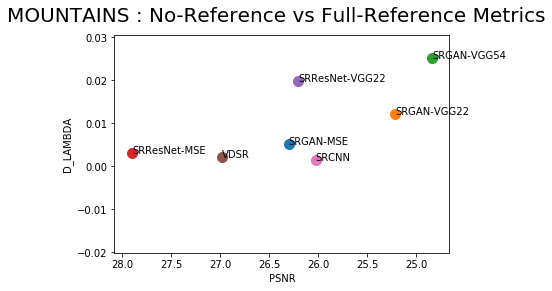

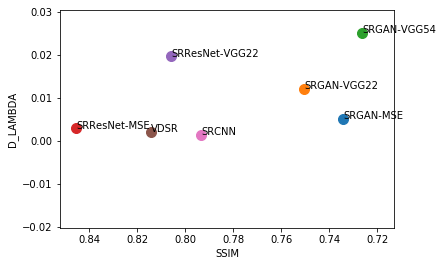

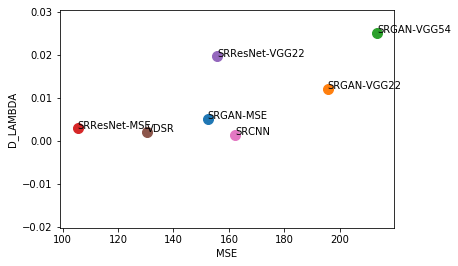

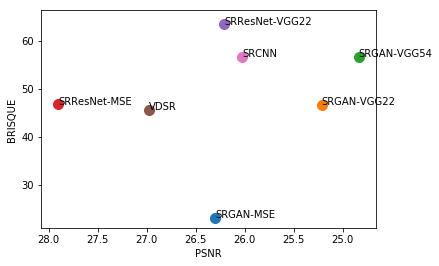

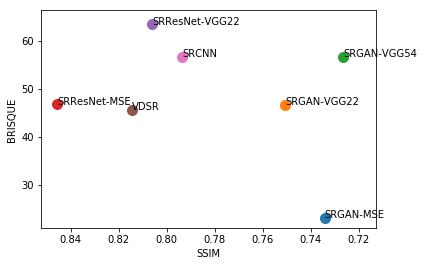

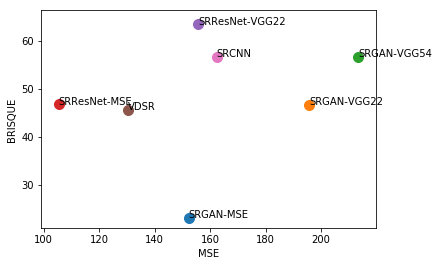

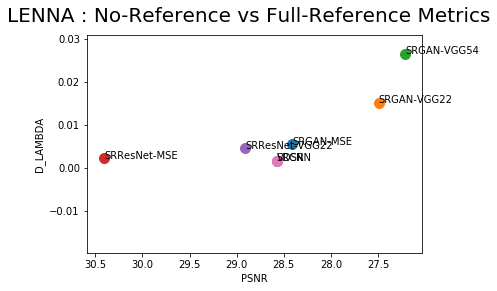

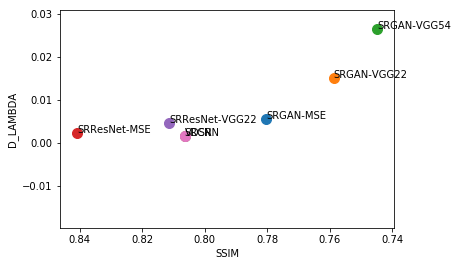

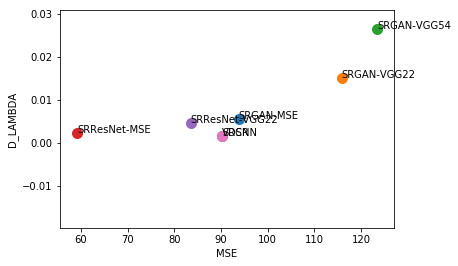

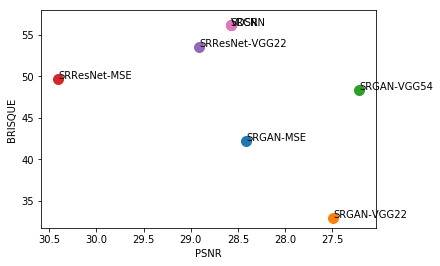

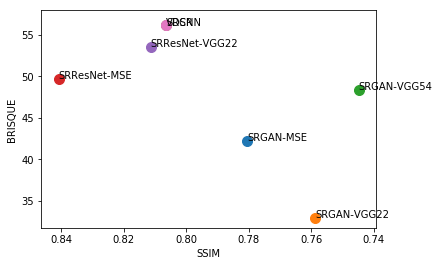

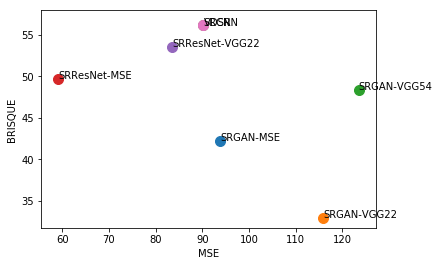

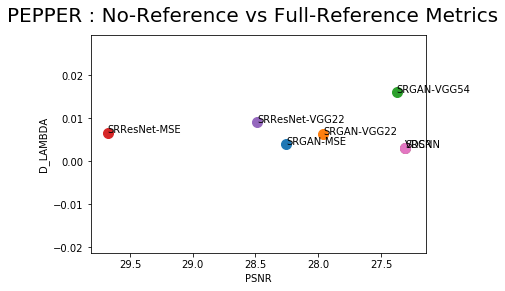

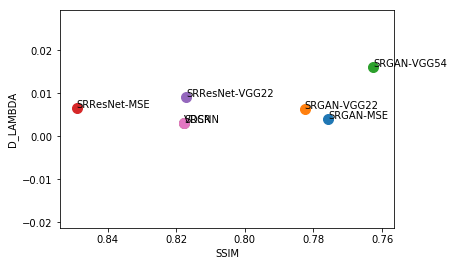

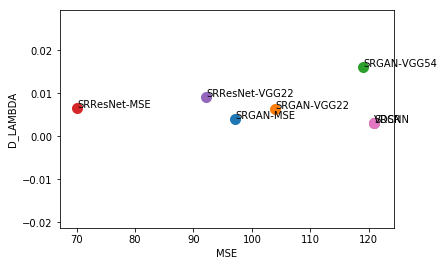

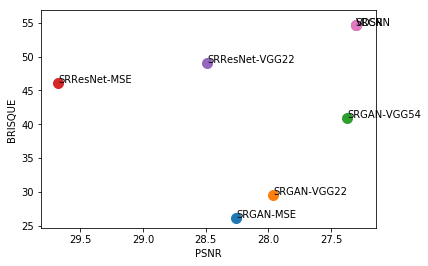

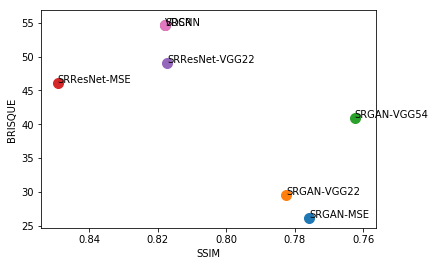

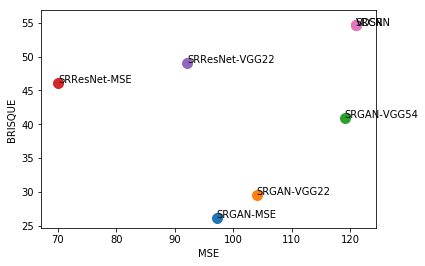

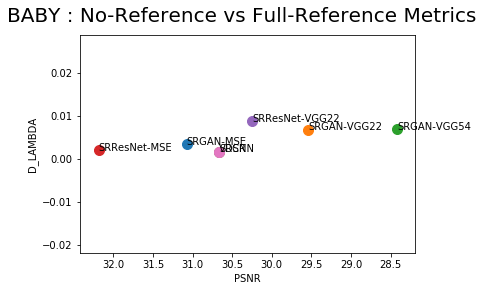

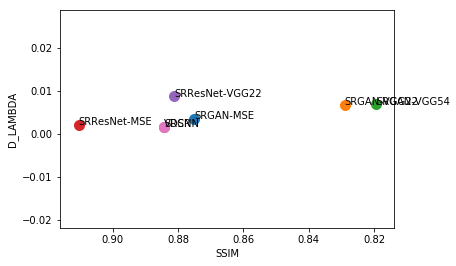

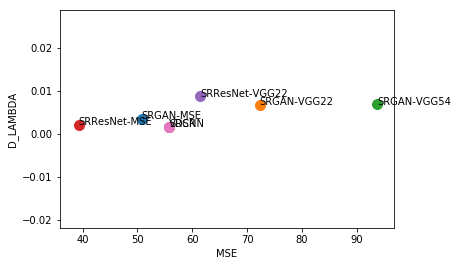

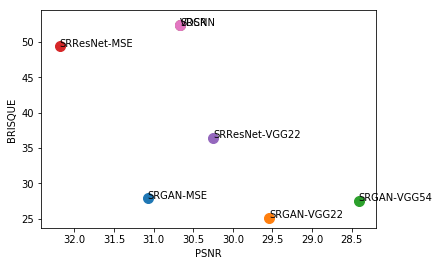

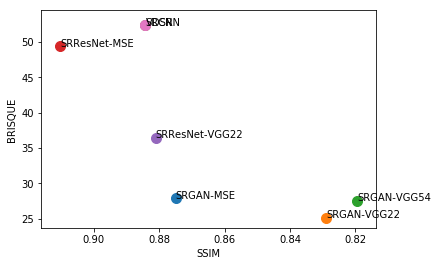

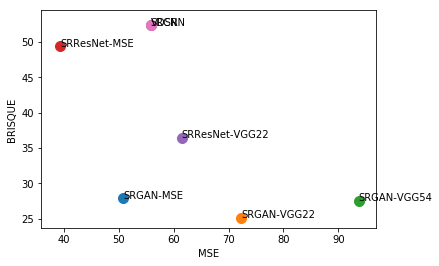

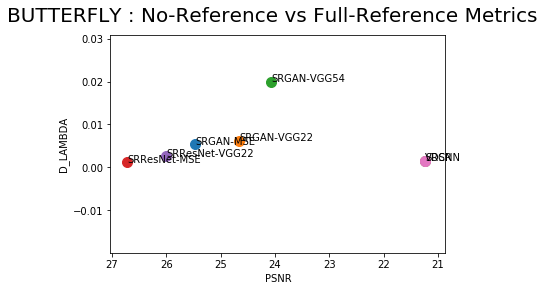

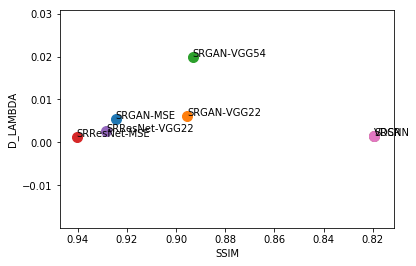

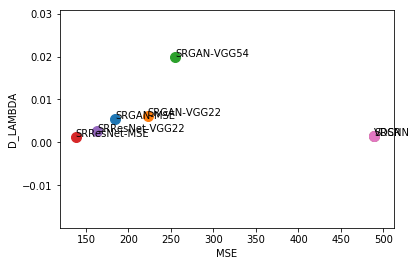

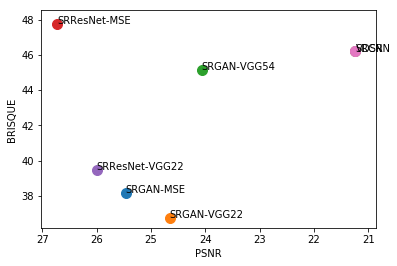

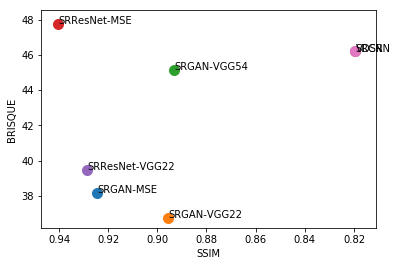

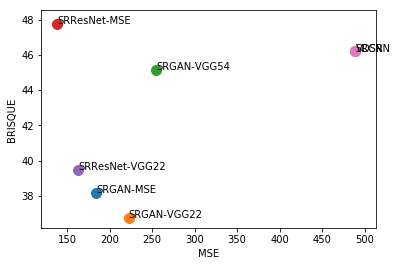

In [12]:
for image_name in image_names:
    values = get_single_image_values(image_name)
    first_plot = True 
    for nr_met in nr_metrics:
        for fr_met in fr_metrics:
            fig = plt.figure(1)
            if first_plot:
                fig.suptitle(image_names[image_name].upper() + " : No-Reference vs Full-Reference Metrics", size=20)
                first_plot = False

            sub = fig.add_subplot(111)

            # points
            labels = []
            x_vals = []
            y_vals = []

            for model in models:
                labels.append(model)
                x_vals.append(values[model][fr_met])
                y_vals.append(values[model][nr_met])

                x, y = values[model][fr_met], values[model][nr_met]
                sub.scatter(x, y, label=model, s=100)
                sub.annotate(model, (x, y))

            # axes and labels
            sub.set_ylabel(nr_met)
            sub.set_xlabel(fr_met)
    #         sub.set_title("Model vs " + plot_metric.upper() + " for " + str(len(plot_images)) + " images")
    #         sub.set_xticks(ind+width)
    #         plt.setp(sub.set_xticklabels(plot_images), rotation=45, fontsize=10)

            # legend
    #         sub.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

            # inverting axis
            if fr_met in axis_reverse:
                plt.gca().invert_xaxis()

            if nr_met in axis_reverse:
                plt.gca().invert_yaxis()

            plt.show()

In [15]:
# name = 'baby'
# save = False

In [16]:
# import srcnn_predict as srcnn
# import vdsr_predict as vdsr

# images = load_images(name)
# image = vdsr.predict(images['bicubic'])

# images = load_images(name)
# image = srcnn.predict(images['bicubic'])

# if save:
#     cv2.imwrite('Tradeoff/Images/' + name + '_VDSR' + '.png', image)
#     cv2.imwrite('Tradeoff/Images/' + name + '_SRCNN' + '.png', image)